In [2]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt
import copy

In [8]:
mesh = ff.base.dcsmesh()
mesh.from_file('..\meshes\dcs\slab_dcs')

tau = np.array([0 , 0.5*(5e-7)])
xgrid = np.arange(0., 120, 1)
ygrid = np.arange(0., 120, 1)
zgrid = np.arange(0., 50, 1)
mesh.gen_intmat(xgrid, ygrid, zgrid)

Sources integration functions loaded
Detectors integration functions loaded


In [9]:
# let's hack the mesh: change the label to standard type, so we can use the standard mesh methods
mesh.type = 'stnd'
# make sure to turn off normalization: we don't need Rytov here
J0,data0,_=ff.inverse.jacobian_stnd_CW(mesh, normalize=0)

Calculating direct field...
Calculating adjoint field...
Integrating...


In [10]:
# now at tau=T/2
k0 = 2*np.pi / (mesh.wv_DCS/1e6)
#Define US parameters
va = 1480*1e3   # acoustic wave velocity
ka = 2*np.pi / (va/(2e6))  # va=1480m/s , fa=2Mhz
wa = 2*np.pi*2e6   # 2*pi*fa
ltr = 1/mesh.mus
rho = 1000*1e-9   # for water
eta = 0.32       # for water
Sa = 1.
phi = 0.

# Define US position
x_cen,y_cen,z_cen = [60,60,30]      #centre of the US
dist = np.sqrt(np.square((mesh.nodes[:,0]-x_cen)) + np.square((mesh.nodes[:,1]-y_cen)) + np.square((mesh.nodes[:,2]-z_cen)))
height = 10  #height of cylinder
dia = 5     #diameter of cylinder
ind= np.zeros(len(mesh.nodes))

for i in range(len(mesh.nodes)):     # selecting nodes for Cylindrical US: Z-axis aligned   
    if mesh.nodes[i,2]>(z_cen-height/2) and mesh.nodes[i,2]<(z_cen+height/2) and np.sqrt((mesh.nodes[i,0]-x_cen)**2+(mesh.nodes[i,1]-y_cen)**2) < dia/2 :
        ind[i] = dist[i] 

selection = np.argwhere(ind != 0)
p0 = np.zeros(len(mesh.mua))
p0[selection] = 1000           #assigning a pressure value to the selected nodes within the cylindrical vol

ht = (np.square((p0*k0*mesh.ri)/(ka*rho*va*va))) * (1-np.cos(wa*tau[1])) * ( (np.square(eta))*(ka*ltr)*(np.arctan(ka*ltr)) + Sa*Sa/3 - 2*eta*Sa/np.cos(phi) )


In [11]:
meshT = ff.base.stndmesh()
meshT.from_copy(mesh)
meshT.mua += meshT.mus*ht
meshT.kappa = 1/(3*(meshT.mua + meshT.mus))

JT, dataT, _ = ff.inverse.jacobian_stnd_CW(meshT, normalize=0)


Calculating direct field...
Calculating adjoint field...
Integrating...


In [55]:
# dc and ac data
y_dc = data0.amplitude
y_ac = y_dc - dataT.amplitude

# J_ac and J_md
J_ac = J0 - JT
# It should be J_AC, not J(T/2)! There's an error in the paper
J_md = (J_ac*y_dc[:,None] - J0*y_ac[:,None])/y_dc[:,None]**2

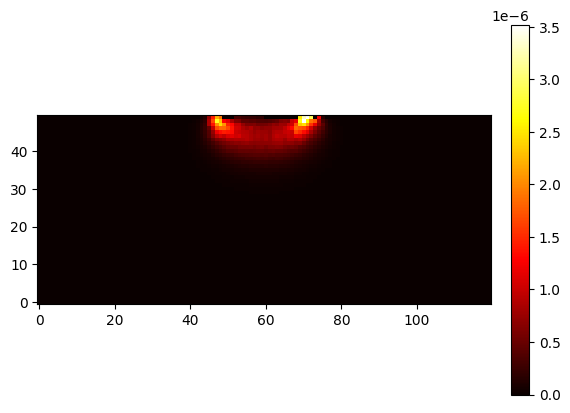

In [27]:
# plot the bananas
banana1 = J0[1,:].reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 
plt.set_cmap('hot')
h = plt.imshow(-banana1[60,:,:].T, origin='lower')
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.show()

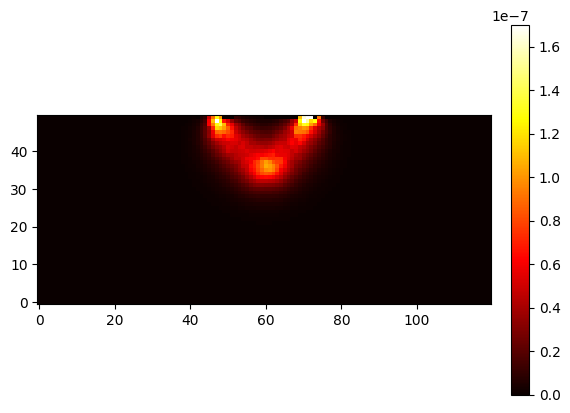

In [52]:
banana_ac = J_ac[1,:].reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 
plt.set_cmap('hot')
h = plt.imshow(-banana_ac[60,:,:].T, origin='lower',vmin=0,vmax=1.7e-7)
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.show()

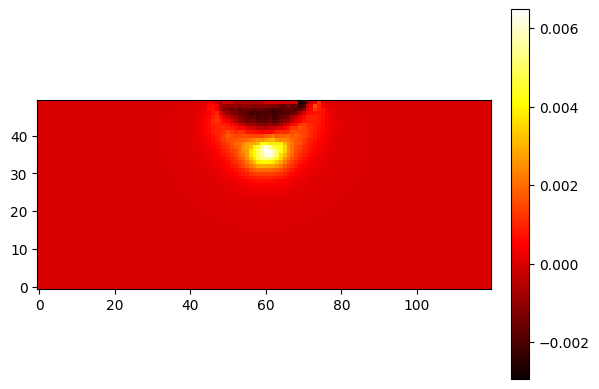

In [67]:
banana_md = J_md[1,:].reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 
plt.set_cmap('hot')


h = plt.imshow(-banana_md[60,:,:].T, origin='lower')
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.show()

In [65]:
# sanity check
# let's forget about the ultrasound for now and directly change the absorption coefficient
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)

dmua = mesh.mua[0]*0.01*np.ones(xgrid.size*ygrid.size*zgrid.size) # 1% increase, uniform
mesh2.change_prop(-1, [mesh.mua[0]+dmua[0], mesh.mus[0], mesh.ri[0]]) # new dc
data0_new = ff.forward.femdata_stnd_CW(mesh2)[0]

meshT2 = ff.base.stndmesh()
meshT2.from_copy(mesh2)
meshT2.mua += meshT2.mus*ht
meshT2.kappa = 1/(3*(meshT2.mua+meshT2.mus))
dataT_new = ff.forward.femdata_stnd_CW(meshT2)[0]

y_dc2 = data0_new.amplitude
y_ac2 = y_dc2 - dataT_new.amplitude

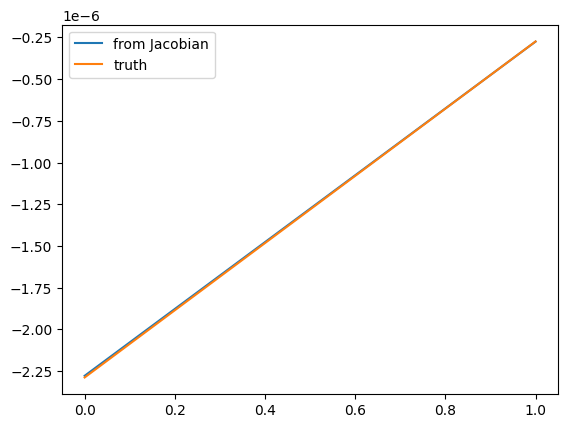

In [66]:
# check dc
dmua = mesh.mua[0]*0.01*np.ones(xgrid.size*ygrid.size*zgrid.size)

plt.plot(J0@dmua)
plt.plot(y_dc2 - y_dc)
plt.legend(['from Jacobian', 'truth'])
plt.show()

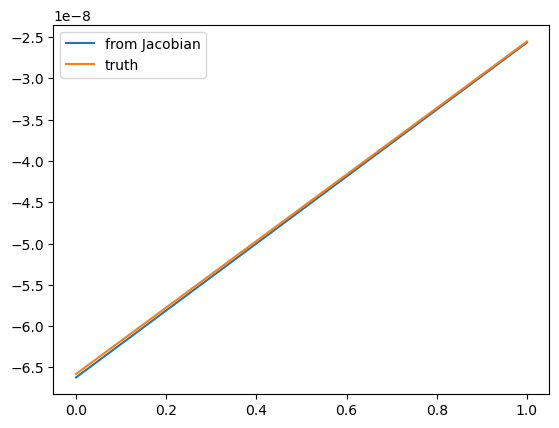

In [12]:
# check ac
plt.plot(J_ac@dmua)
plt.plot(y_ac2 - y_ac)
plt.legend(['from Jacobian', 'truth'])

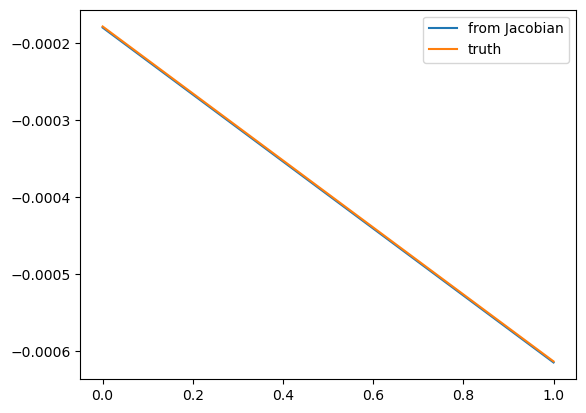

In [13]:
# check md
plt.plot(J_md@dmua)
plt.plot(y_ac2/y_dc2 - y_ac/y_dc)
plt.legend(['from Jacobian', 'truth'])
